# Neural encoding 1

TODO - include figure here -> spikes - neuron - LIF - spikes

In [70]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

#### Data Retrieval - Exploring the Steinmetz dataset
In this tutorial we will explore the structure of a neuroscience dataset.

We consider a subset of data from a study of [Steinmetz et al. (2019)](https://www.nature.com/articles/s41586-019-1787-x). In this study, Neuropixels probes were implanted in the brains of mice. Electrical potentials were measured by hundreds of electrodes along the length of each probe. Each electrode’s measurements captured local variations in the electric field due to nearby spiking neurons. A spike sorting algorithm was used to infer spike times and cluster spikes according to common origin: a single cluster of sorted spikes is causally attributed to a single neuron.

In particular, a single recording session of spike times and neuron assignments was loaded and assigned to spike_times in the preceding setup.

Typically a dataset comes with some information about its structure. However, this information may be incomplete. You might also apply some transformations or “pre-processing” to create a working representation of the data of interest, which might go partly undocumented depending on the circumstances. In any case it is important to be able to use the available tools to investigate unfamiliar aspects of a data structure.

Let’s see what our data looks like…

In [2]:
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [3]:
spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)

for key in spike_times: 
    print (key)

spike_times


[(0.0, 500.0)]

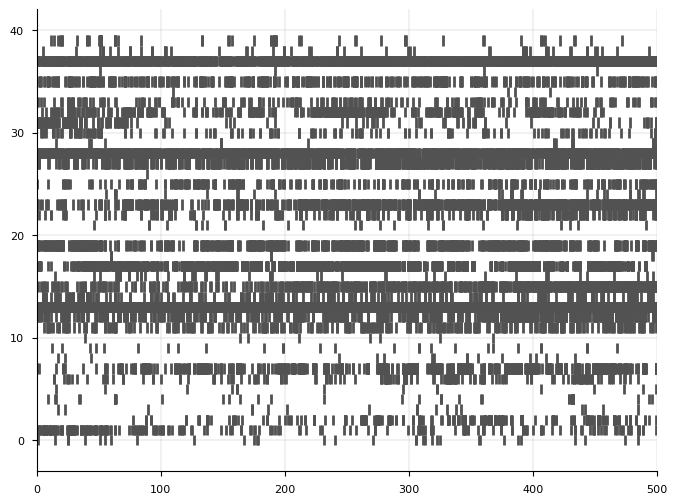

In [6]:
fig, ax = plt.subplots()
ax.eventplot(spike_times['spike_times'][:40], color='#525252')
ax.set(xlim = (0,500))

In [7]:
# https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files

# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [8]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

(1070, 251, 250)


[(0.0, 2500.0)]

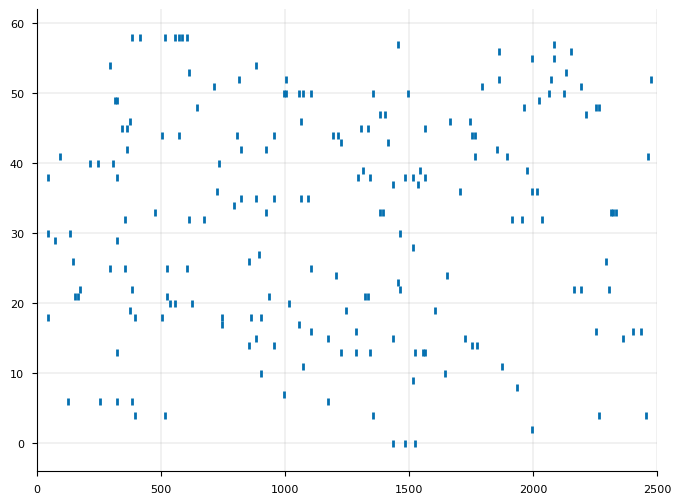

In [9]:
dat = alldat[1]
# for key in dat['spks']:
#     print (len(key))

# for key in dat:
#     print (key)

# neurons, trials, time_bins
print (dat['spks'].shape)


single_trial = dat['spks'][0,0,:]

def transform_to_event_input(binned_spikes):
    bin_size = 10
    bin_offset = 5
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times

    
    
fig, ax = plt.subplots()

for ii in range(0,60):
    _, spike_times = transform_to_event_input(dat['spks'][14,ii,:])
    ax.eventplot(spike_times, lineoffsets=ii)

ax.set(
    xlim = (0,2500)
)

$w(\tau) = \left[\alpha^2 \tau \exp(-\alpha \tau)\right]_+$

[more info on spikes to rates](https://www.youtube.com/watch?v=Ef7_qnLOh70)

In [46]:
def get_filter_array(filter_shape):
    
    filter_array = None
    
    if filter_shape == 'large rectangle':
        filter_array = np.ones(25)
        
    if filter_shape == 'small rectangle':
        filter_array = np.ones(11)
    
    if filter_shape == 'gaussian, sigma = 25':
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        filter_array = gaussian(np.linspace(0,159,159), 79.5, 25)

        
    if filter_shape == 'gaussian, sigma = 8':
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        filter_array = gaussian(np.linspace(0,63,63), 31.5, 8)
    
    
    if filter_shape == 'causal':
        def causal(alpha, x):
            result = alpha**2*x*np.exp(-alpha*x)
            result[result <0] = 0
            return result
        filter_array = causal(0.2,np.linspace(0,63,63))
        filter_array /= np.max(filter_array)
        
    return filter_array

In [47]:

def visualize_filtering(pos, filter_shape = 'rectangle', trial_number = 0):
    
    filter_array = get_filter_array(filter_shape = filter_shape)
            
            
        
        
    single_trial = dat['spks'][0,trial_number,:]
    
    
    shift_ = 80
    shifted_trial = np.hstack([np.zeros(shift_),single_trial, np.zeros(shift_)])
    
    bin_times, spike_times = transform_to_event_input(single_trial)
            
    
    fig,axes = plt.subplots(2)
    axes[0].eventplot(spike_times, label = 'spikes')
    axes[0].set(
    xlim = (0,2500),
    ylim = (-0.1,2.8))

    filter_backbone = np.zeros_like(shifted_trial)
    new_bin_times = np.hstack([np.zeros(shift_)*float('nan'),bin_times,np.zeros(shift_)*float('nan')])
    
    shifted_pos = pos + shift_
    filter_backbone[shifted_pos -len(filter_array)//2:shifted_pos +len(filter_array)//2+1] = filter_array
    axes[0].plot(new_bin_times, filter_backbone, color='#feb24c', label='filter')
    axes[0].plot([new_bin_times[shifted_pos],new_bin_times[shifted_pos]],[0,0.2],color='#de2d26', label='time point')
    axes[0].plot([new_bin_times[shift_+2],new_bin_times[shift_+27]],[0.2,0.2],color='k')
    axes[0].annotate('250 ms', xy=([new_bin_times[shift_+2], 0.25]),  xycoords='data',
            xytext=([new_bin_times[shift_+5], 0.25]), textcoords='data')
    
    axes[0].axis('off')
    axes[0].legend()
    
    filtered_signal = np.zeros_like(shifted_trial)
    for ii in range(shift_,shifted_pos):
        filtered = 100*len(filter_array) * np.mean(shifted_trial[ii-len(filter_array)//2:ii+len(filter_array)//2+1] * filter_array/np.sum(filter_array))
        filtered_signal[ii] = filtered

    
    axes[1].plot(new_bin_times, filtered_signal, label= 'rate')
    axes[1].legend()
    axes[1].set(
        xlim=(0,2500),
        xlabel = 'Time in ms',
        ylabel = 'Firing rate in Hz',
    )


widgets.interactive(visualize_filtering, 
                    pos = (0,250,1), 
                    filter_shape = ['large rectangle','small rectangle','gaussian, sigma = 8','gaussian, sigma = 25','causal'],
                   trial_number = (0,100,1))

interactive(children=(IntSlider(value=125, description='pos', max=250), Dropdown(description='filter_shape', o…

#  Do the same but for averaging across trials

this is essentially another interpretation

In [57]:
# neuron 70, 77

def multiple_trials(neuron_id = 70, filter_shape = 'large rectangle'):

    fig, (ax_0, ax_1, ax_2) = plt.subplots(3,1, sharex = True, gridspec_kw={'height_ratios': [3, 1,1]})
    n_trials = 100
    all_trials = np.zeros_like(dat['spks'][neuron_id,0,:])
    for trial_number in range(0,n_trials):
        single_trial = dat['spks'][neuron_id,trial_number,:]
        _, spike_times = transform_to_event_input(single_trial)
        ax_0.eventplot(spike_times, lineoffsets=trial_number)
        all_trials += single_trial
        
    ax_0.axvline(x = 500, c ='#99000d', linewidth = 1 , linestyle = '--')

    ax_0.set(
        xlim = (0,2500),
        ylabel = 'Trial Number',
    )
    
    X = np.linspace(0,2490,250)
    ax_1.bar(X,all_trials, width=10)
    ax_1.set(
        ylabel = 'PSTH',
    )
    
    filter_array = get_filter_array(filter_shape = filter_shape)
    
    shift_ = 80
    shifted_array = np.hstack([np.zeros(shift_),all_trials, np.zeros(shift_)])
    
    filtered_array = np.zeros_like(shifted_array)
    for ii in range(shift_,250+shift_):
        filtered = len(filter_array) * np.mean(shifted_array[ii-len(filter_array)//2:ii+len(filter_array)//2+1] * filter_array/np.sum(filter_array))
        filtered_array[ii] = filtered
    
    
    ax_2.plot(X,filtered_array[shift_:-shift_])
    ax_2.set(
        xlabel = 'Time in ms',
        ylabel = 'Smooth PSTH',
        
    )

    
    
widgets.interactive(multiple_trials, 
                    neuron_id = (0,100,1),
                   filter_shape = ['large rectangle','small rectangle','gaussian, sigma = 8','gaussian, sigma = 25','causal'])

interactive(children=(IntSlider(value=70, description='neuron_id'), Dropdown(description='filter_shape', optio…

$\Delta t$

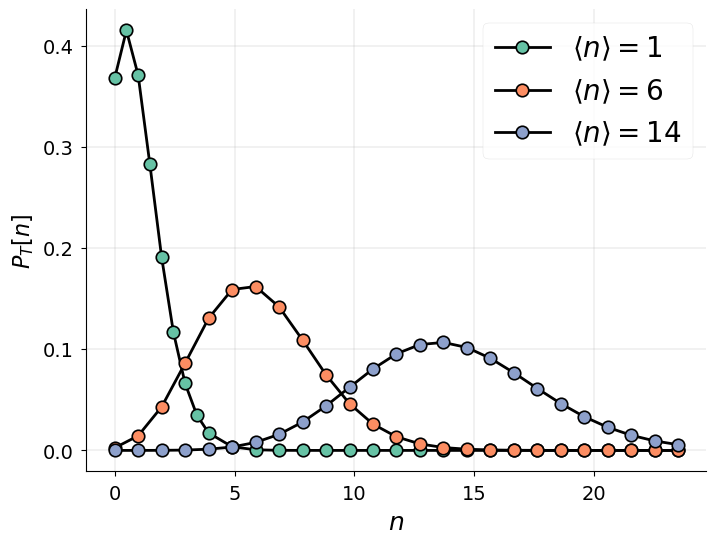

In [115]:
def poisson(n,n_expect):
    return (n_expect)**n/scipy.special.factorial(n) * np.exp(-n_expect)

fig, ax = plt.subplots()


for ii, color in zip([1,6,14],['#66c2a5','#fc8d62','#8da0cb']):
    if ii == 1:
        X = np.hstack([np.linspace(0,24)[:8],np.linspace(0,24)[8::2]])
    else:
        X = np.linspace(0,24)[::2]
    ax.plot(X,poisson(X,n_expect=ii), 
            color = 'k', marker = 'o', markersize=9, 
            markeredgecolor = 'k', markeredgewidth=1.2,
            markerfacecolor = color, label = r'$\langle n \rangle = $' + f'{ii}')

ax.set_xlabel('$n$', fontsize=18)
ax.set_ylabel('$P_T[n]$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size': 20})
plt.savefig('Poisson Distributions', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )